In [47]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import time
import datetime
import copy
from tqdm import tqdm_notebook as tqdm
from PIL import Image
from sklearn.model_selection import train_test_split, StratifiedKFold

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

In [48]:
torch.__version__

'1.3.1'

In [49]:
torch.cuda.empty_cache()

---
# Metadata

In [50]:
data_dir = '..\\input'

metadata_path = glob.glob(os.path.join(data_dir, '*.json'))

In [51]:
# load metadata
metadata = pd.DataFrame()
for path in metadata_path:
    metadata = pd.concat([metadata, pd.read_json(path).T], axis=0)
    
metadata.reset_index(inplace=True)
metadata = metadata.rename(columns={'index': 'mov'})

In [52]:
metadata.head()

,mov,label,split,original
0,owxbbpjpch.mp4,FAKE,train,wynotylpnm.mp4
1,vpmyeepbep.mp4,REAL,train,NaN
2,fzvpbrzssi.mp4,REAL,train,NaN
3,htorvhbcae.mp4,FAKE,train,wclvkepakb.mp4
4,fckxaqjbxk.mp4,FAKE,train,vpmyeepbep.mp4


In [53]:
# Label
metadata['label'].value_counts()

FAKE    5593
REAL     643
Name: label, dtype: int64

In [54]:
# 1Real movie 1 fake
mov_path = []
real_list = metadata[metadata['label'] == 'REAL']['mov'].tolist()
for path in real_list:
    mov_path.append(metadata[metadata['original'] == path]['mov'].tolist()[0])
mov_path.extend(real_list)
mov_path = [os.path.join(data_dir, path) for path in mov_path]

---
# Movie to Image

In [55]:
def get_img_from_mov(video_file, show_img=False):
    # https://note.nkmk.me/python-opencv-videocapture-file-camera/
    cap = cv2.VideoCapture(video_file)
    frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    image_list = []
    for i in range(frames):
        _, image = cap.read()
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_list.append(image)
    cap.release()

    if show_img:
        fig, ax = plt.subplots(1,1, figsize=(15, 15))
        ax.imshow(image[0])
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.title.set_text(f"FRAME 0: {video_file.split('/')[-1]}")
        plt.grid(False)
        
    return image_list

---
# Face Detection

In [56]:
def detect_face(img):
    # Add Dataset "Haarcascades"
    face_cascade = cv2.CascadeClassifier('..\\haarcascade\\haarcascade_frontalface_alt.xml')
    face_crops = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5)
    
    if len(face_crops) == 0:
        return []
    
    crop_imgs = []
    for i in range(len(face_crops)):
        x = face_crops[i][0]
        y = face_crops[i][1]
        w = face_crops[i][2]
        h = face_crops[i][3]
        #x,y,w,h=ratio*x,ratio*y,ratio*w,ratio*h
        crop_imgs.append(img[y:y+h, x:x+w])
    return crop_imgs

---
# Search Face Detection

In [57]:
# Find Movie which cannot detect face
def detect_noface_mov(mov_path, search_img_num=None):
    no_face_detect_mov = []

    for mov in tqdm(mov_path):
        # VideoCapture
        image = get_img_from_mov(mov)
        flag = 0
        
        if search_img_num is None:
            num = len(image)
        else:
            num = search_img_num + 1
        
        for idx in range(num):
            crop = detect_face(image[idx])

            if crop != []:
                flag += 1
            else:
                pass

        if flag == 0:
            no_face_detect_mov.append(mov)
        else:
            pass
    
    df = pd.DataFrame({
        'id': np.arange(len(no_face_detect_mov)),
        'mov': no_face_detect_mov
    })
        
    return df

In [58]:
# no_face_detect_mov_frame = detect_noface_mov(mov_path, search_img_num=0)
# no_face_detect_mov_frame.to_csv('../input/no_face_mov_01.csv', index=False)

---
# Dataset

In [59]:
class Resize(object):
    def __init__(self, size=300):
        self.size = size

    def __call__(self, image):
        image = cv2.resize(image, (self.size,
                                 self.size))
        return image

# Data Augumentation
class ImageTransform():
    def __init__(self, resize):
        self.data_transform = {
            'train': transforms.Compose([
                Resize(resize),
                transforms.ToTensor(),
            ]),
            'val': transforms.Compose([
                Resize(resize),
                transforms.ToTensor(),
            ])
        }
        self.size = resize
        
    def __call__(self, img, phase):
        return self.data_transform[phase](img)


class DeepfakeDataset(Dataset):
    def __init__(self, file_list, metadata, transform=None, phase='train'):
        self.file_list = file_list
        self.metadata = metadata
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        mov_path = self.file_list[idx]
        
        # Label
        label = self.metadata[self.metadata['mov'] == mov_path.split('\\')[-1]]['label'].values
        
        if label == 'FAKE':
            label = 1
        else:
            label = 0
        
        # Movie to Image
        for i in range(30):
            try:
                image = get_img_from_mov(mov_path, show_img=False)[i*10]
                # FaceCrop
                image = detect_face(image)[0]
                # Transform
                image = self.transform(image, self.phase)
                # When the face is detected, exit from the loop
                if torch.is_tensor(image):
                    break
            except:
                image = None
                pass
            
        # When the face cannot be detected...
        if image is None:
            image = torch.ones((3, self.transform.size, self.transform.size), dtype=torch.float)
            label = 0.5
        
        return image, label, mov_path
    
    
class DeepfakeDataset_idx0(Dataset):
    def __init__(self, file_list, metadata, transform=None, phase='train'):
        self.file_list = file_list
        self.metadata = metadata
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        
        mov_path = self.file_list[idx]
        
        # Label
        label = self.metadata[self.metadata['mov'] == mov_path.split('\\')[-1]]['label'].values
        
        if label == 'FAKE':
            label = 1
        else:
            label = 0
        
        # Movie to Image
        try:
            image = get_img_from_mov(mov_path, show_img=False)[0]
            # FaceCrop
            image = detect_face(image)[0]
            # Transform
            image = self.transform(image, self.phase)
        except:
            image = torch.ones((3, self.transform.size, self.transform.size), dtype=torch.float)
            label = 0.5
        
        return image, label, mov_path

---
# Model

In [60]:
# VGG19
use_pretrained = True
net = models.vgg19(pretrained=use_pretrained)
# Change Last Layer
# Output Features 1000 → 2
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# Specify The Layers for updating
params_to_update = []
update_params_name = ['classifier.6.weight', 'classifier.6.bias']

for name, param in net.named_parameters():
    if name in update_params_name:
        param.requires_grad = True
        params_to_update.append(param)
    else:
        param.requires_grad = False
print('Done')

Done


---
# Train

In [61]:
# Set RawData  #########################################################
# Divide Train, Valid Dataset
train_mov_path, val_mov_path = train_test_split(mov_path, test_size=0.1)

# Config  #########################################################
size = 224
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 32
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)

# Dataset  #########################################################
train_dataset = DeepfakeDataset_idx0(train_mov_path, metadata, ImageTransform(size), 'train')
val_dataset = DeepfakeDataset_idx0(val_mov_path, metadata, ImageTransform(size), 'val')

# Dataloader  #########################################################
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
dataloader_dict = {
    'train': train_dataloader,
    'val': val_dataloader
}


In [62]:
def train_model(net, dataloader_dict, criterion, optimizer, num_epoch):
    
    since = time.time()
    best_model_wts = copy.deepcopy(net.state_dict())
    best_acc = 0.0
    net = net.to(device)
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch + 1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:
            
            if phase == 'train':
                net.train()
            else:
                net.eval()
                
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels, _ in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device, dtype=torch.long)
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                    epoch_loss += loss.item() * inputs.size(0)
                    epoch_corrects += torch.sum(preds == labels.data)
                    
                del inputs, labels
                torch.cuda.empty_cache()
                    
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(net.state_dict())
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    net.load_state_dict(best_model_wts)
    return net

In [ ]:
# Train
num_epoch = 5
net = train_model(net, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/5
--------------------


d:\python\kaggle\deepfa~1\env\venv~1\lib\site-packages\ipykernel_launcher.py:22: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [16]:
# Save Model
date = datetime.datetime.now().strftime('%Y%m%d')
torch.save(net.state_dict(), "../model/vgg19_ep{}_{}.pth".format(num_epoch, date))

---
# Prediction

In [17]:
# Prediction
label_list = []
pred_list = []
path_list = []

with torch.no_grad():
    for img, label, mov_path in tqdm(val_dataset):
        img = img.unsqueeze(0)
        img = img.to(device)

        net.eval()

        outputs = net(img)
        preds = F.softmax(outputs, dim=1)[:, 1].tolist()
        
        label_list.append(label)
        pred_list.append(preds[0])
        path_list.append(mov_path)
    
res = pd.DataFrame({
    'label': label_list,
    'pred': pred_list,
    'path': path_list
})

res.to_csv('../output/submission_vgg19.csv', index=False)

d:\python\kaggle\deepfa~1\env\venv~1\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [18]:
res

,label,pred,path
0,1,0.987737,..\input\iwhrsvsqcs.mp4
1,1,0.996737,..\input\yuozmggtin.mp4
2,1,0.995407,..\input\doiljuhamq.mp4
3,1,0.905448,..\input\owmzjclufi.mp4
4,1,0.990909,..\input\okrrtlhqlz.mp4
...,...,...,...
85,1,0.997594,..\input\enpnclhmik.mp4
86,1,0.997899,..\input\dwardtgkwh.mp4
87,1,0.985861,..\input\uqfnqniamo.mp4
88,1,0.974265,..\input\hcanfkwivl.mp4


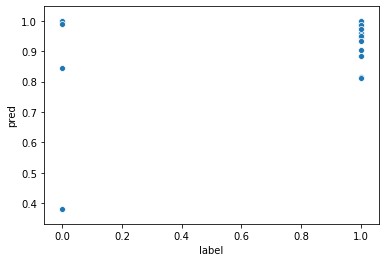

In [19]:
import seaborn as sns
sns.scatterplot(x='label', y='pred', data=res)